FACIAL EXPRESSIONS RECONGITION

In [ ]:
#Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import joblib
import os
from tensorflow.keras.callbacks import EarlyStopping

import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

Load Dataset

In [5]:
#load the both train and validation dataset
train_data_dir = 'C:/Emotion_detection/train'
validation_data_dir= 'C:/Emotion_detection/test'

Data Preprocessing

In [6]:
# Create an instance of ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
                rescale=1./255,  # Rescale pixel values to the range [0, 1] by dividing by 255
                rotation_range=30,
                shear_range=0.3,
                zoom_range=0.3,
                horizontal_flip=True,
                fill_mode='nearest')

# Create an instance of ImageDataGenerator for validation data without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)
                            


In [14]:
# Generate batches of augmented image data from the training directory
train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    color_mode='grayscale',   # Load images in grayscale mode
                    target_size=(48,48),  #Resize all images to a target size of 48x48 pixels
                    batch_size=64,
                   class_mode='categorical',
                    shuffle=True)


# Generate batches of image data from the validation directory
validation_generator = validation_datagen.flow_from_directory(
                        validation_data_dir,
                        color_mode='grayscale',
                        target_size=(48,48),
                        batch_size=64,
                        class_mode='categorical',
                        shuffle=True)

# List of class labels corresponding to the categories in the dataset
class_labels=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# Get the next batch of images and labels from the training data generator
img, label = train_generator.__next__()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
#number of train images
train_path = "/Emotion_detection/train"


num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)



print(num_train_imgs)

#number of Test Images

test_path = "/Emotion_detection/test"
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)


print(num_test_imgs)



28709
7178


Data Visualisation

In [16]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (48, 48))
                img = img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(r'C:\Emotion_detection\train')
test_images, test_labels = load_images_from_folder(r'C:\Emotion_detection\test')


In [50]:
# Assuming you have already loaded your data
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Unique labels: {np.unique(train_labels)}")


Train images shape: (28709, 48, 48, 1)
Test images shape: (7178, 48, 48, 1)
Unique labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


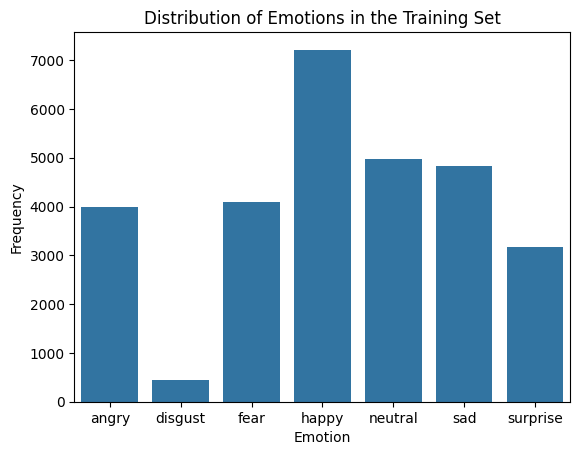

In [51]:
# Count plot for Train data set
sns.countplot(x=train_labels)
plt.title('Distribution of Emotions in the Training Set')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()


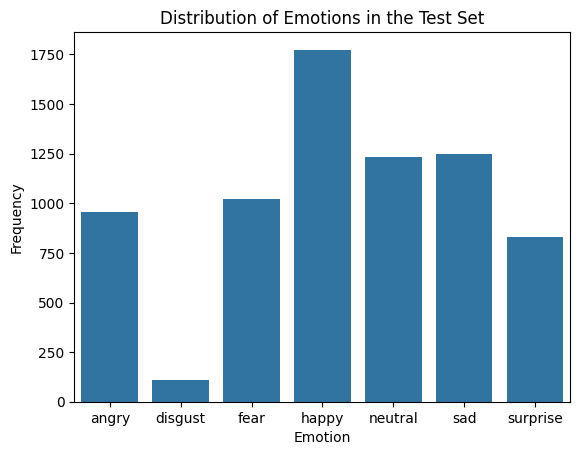

In [52]:
#Count Bar plot for tset data set

sns.countplot(x=test_labels)
plt.title('Distribution of Emotions in the Test Set')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()


Feature Engineering

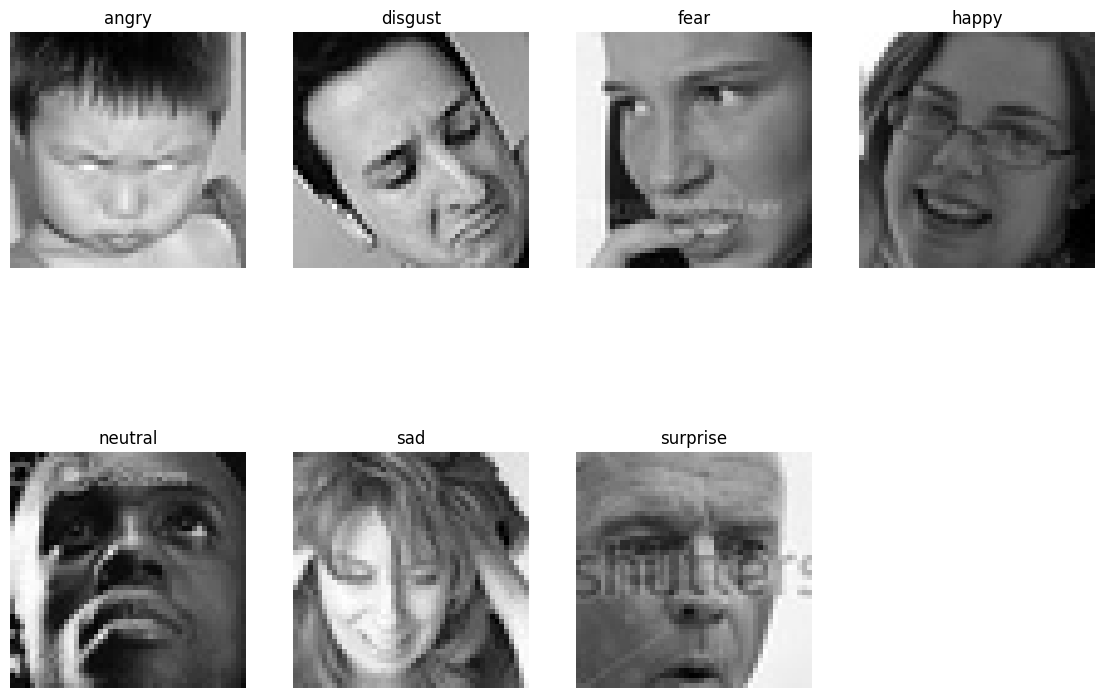

In [17]:
# Convert labels to numeric values (if needed)


label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
emotion_names = label_encoder.inverse_transform(np.unique(train_labels))

plt.figure(figsize=(14, 10))
for i, emotion in enumerate(np.unique(train_labels)):
    plt.subplot(2, 4, i + 1)
    sample_image = train_images[train_labels == emotion][0]
    plt.imshow(sample_image.squeeze(), cmap='gray')
    plt.title(emotion_names[i])
    plt.axis('off')
plt.show()


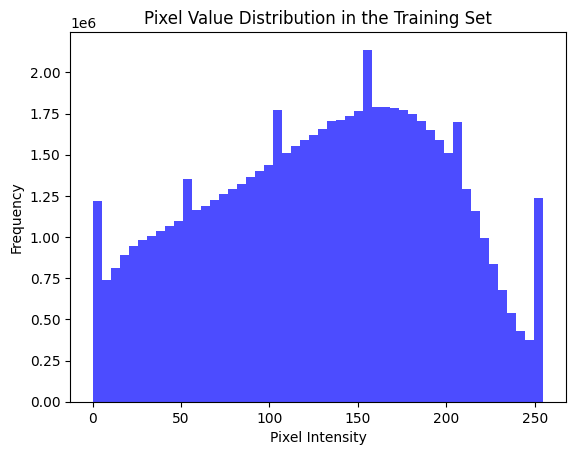

In [54]:
#Pixel Dustribution
plt.hist(train_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution in the Training Set')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


Build Model (CNN)

In [55]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))




model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
print(model.summary())

c:\Emotion_detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,095 (9.50 MB)

 Trainable params: 2,489,095 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

None


Train Model

In [56]:
# Train the CNN model
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor
    patience=5,                 # Number of epochs to wait for improvement
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the CNN model with early stopping
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Pass the early stopping callback here
)

Epoch 1/30


c:\Emotion_detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 310ms/step - accuracy: 0.2426 - loss: 1.8159 - val_accuracy: 0.2988 - val_loss: 1.7026
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 144s 320ms/step - accuracy: 0.2978 - loss: 1.7145 - val_accuracy: 0.4220 - val_loss: 1.5034
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 331ms/step - accuracy: 0.3858 - loss: 1.5754 - val_accuracy: 0.4426 - val_loss: 1.4306
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 329ms/step - accuracy: 0.4299 - loss: 1.4787 - val_accuracy: 0.5020 - val_loss: 1.3069
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 147s 328ms/step - accuracy: 0.4692 - loss: 1.3928 - val_accuracy: 0.5266 - val_loss: 1.2328
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 323ms/step - accuracy: 0.4874 - loss: 1.3316 - val_accuracy: 0.5503 - val_loss: 1.1784
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 150s 334ms/step - accuracy: 0.5031 - loss: 1.3024 - val_accuracy: 0.5502 - val_loss: 1.1825
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - accuracy: 0.5112 - loss: 1.27

In [71]:
# Print the training and validation metrics
print("Training and Validation Metrics:")
print("\nEpoch\tTrain Loss\tTrain Accuracy\tVal Loss\tVal Accuracy")

for epoch in range(len(history.history['loss'])):
    train_loss = history.history['loss'][epoch]
    train_accuracy = history.history['accuracy'][epoch]
    val_loss = history.history['val_loss'][epoch]
    val_accuracy = history.history['val_accuracy'][epoch]
    print(f"{epoch+1}\t{train_loss:.4f}\t{train_accuracy:.4f}\t{val_loss:.4f}\t{val_accuracy:.4f}")

Training and Validation Metrics:

Epoch	Train Loss	Train Accuracy	Val Loss	Val Accuracy
1	1.7900	0.2570	1.7026	0.2988
2	1.6919	0.3151	1.5034	0.4220
3	1.5496	0.3974	1.4306	0.4426
4	1.4507	0.4402	1.3069	0.5020
5	1.3813	0.4696	1.2328	0.5266
6	1.3288	0.4889	1.1784	0.5503
7	1.2958	0.5059	1.1825	0.5502
8	1.2721	0.5123	1.1589	0.5587
9	1.2551	0.5182	1.1374	0.5701
10	1.2324	0.5305	1.1431	0.5632
11	1.2162	0.5361	1.1347	0.5697
12	1.2085	0.5411	1.1257	0.5726
13	1.1902	0.5490	1.1088	0.5814
14	1.1844	0.5505	1.0833	0.5908
15	1.1748	0.5541	1.0927	0.5889
16	1.1615	0.5609	1.0954	0.5893
17	1.1561	0.5619	1.0632	0.5929
18	1.1468	0.5676	1.0784	0.5854
19	1.1472	0.5655	1.0536	0.6031
20	1.1287	0.5724	1.0733	0.5952
21	1.1322	0.5705	1.0783	0.5970
22	1.1314	0.5689	1.0423	0.6110
23	1.1166	0.5769	1.0430	0.6088
24	1.1157	0.5788	1.0474	0.6105
25	1.1024	0.5838	1.0523	0.6084
26	1.1016	0.5811	1.0534	0.6032
27	1.1015	0.5816	1.0311	0.6110
28	1.0942	0.5851	1.0402	0.6117
29	1.0901	0.5873	1.0480	0.6119
30	1.0845	0.5932	1.050

In [72]:
# Evaluate the model on the test dataset (using the validation_generator as the test data)
test_loss, test_acc = model.evaluate(validation_generator)

# Print the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6117 - loss: 1.0168
Test Loss: 1.0311
Test Accuracy: 0.6110


In [73]:
# Evaluate the model on the training dataset
train_loss, train_acc = model.evaluate(train_generator)

# Print the training loss and accuracy
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc:.4f}")

449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.6130 - loss: 1.0158
Training Loss: 1.0134
Training Accuracy: 0.6159


CNN Model Evaluation 

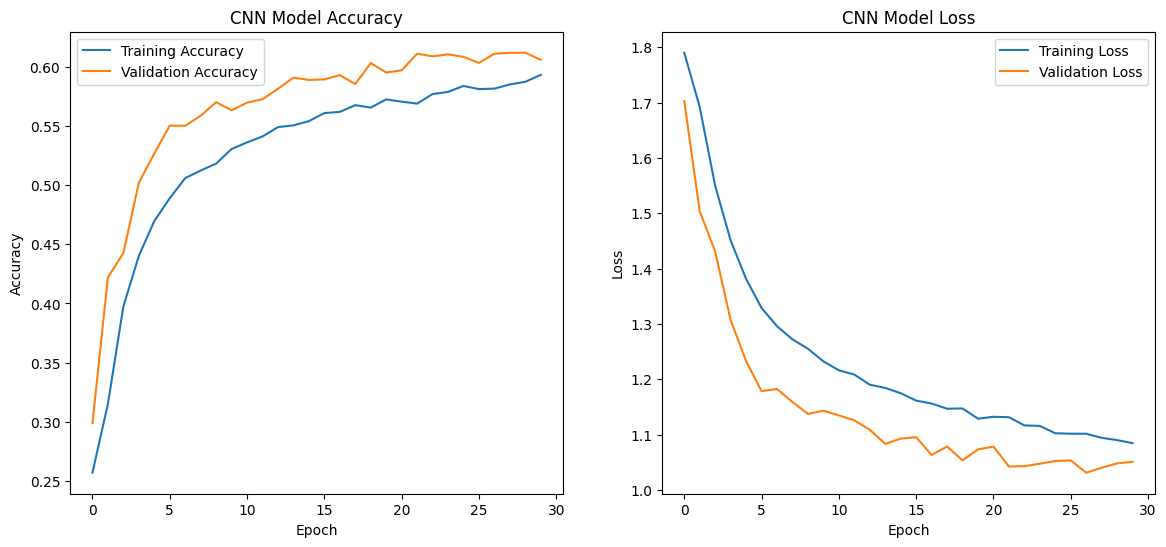

In [61]:
# Plot CNN accuracy, validation accuracy, loss, and validation loss
plt.figure(figsize=(14, 6))


# Plot accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [70]:
#save model

#model.save('model_file.h5')
#model.save('model_file.keras')

# Save the trained model
model_save_path = 'C:/Emotion_detection/saved_model.h5'  # Specify the path where you want to save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:/Emotion_detection/saved_model.h5


SVM Model and Evaluation

In [18]:
# List of class labels corresponding to the categories in the dataset
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Flatten the images in the training dataset
X_train_flat = np.array([img_to_array(img).flatten() for img in train_generator[0][0]])
y_train = np.argmax(train_generator[0][1], axis=1)

# Flatten the images in the training dataset
X_test_flat = np.array([img_to_array(img).flatten() for img in validation_generator[0][0]])
y_test = np.argmax(validation_generator[0][1], axis=1)

# Check the unique classes in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure that the number of unique classes matches the class_labels
if len(unique_classes) != len(class_labels):
    raise ValueError(f"Mismatch between the number of classes in y_train ({len(unique_classes)}) and class_labels ({len(class_labels)}).")

# Define the SVM model and the hyperparameters to tune
svm_model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

# Perform hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)
grid_search.fit(X_test_flat, y_test)

# Get the best model
best_svm = grid_search.best_estimator_

# Make predictions with the best model
y_pred_svm = best_svm.predict(X_test_flat)

# Print the accuracy and classification report
print("SVM Accuracy: ", accuracy_score(y_train, y_pred_svm))
print(classification_report(y_train, y_pred_svm, target_names=class_labels))

# Save the best SVM model
joblib.dump(best_svm, 'best_svm_model.pkl')


Unique classes in y_train: [0 1 2 3 4 5 6]
Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Emotion_detection\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVM Accuracy:  0.234375
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00        14
     Disgust       0.00      0.00      0.00         2
        Fear       0.00      0.00      0.00        11
       Happy       0.32      0.76      0.45        17
     Neutral       0.09      0.20      0.12        10
         Sad       0.00      0.00      0.00         7
    Surprise       0.00      0.00      0.00         3

    accuracy                           0.23        64
   macro avg       0.06      0.14      0.08        64
weighted avg       0.10      0.23      0.14        64



c:\Emotion_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Emotion_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Emotion_detection\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['best_svm_model.pkl']

SVM Model